<a href="https://colab.research.google.com/github/gokul-00/FYP/blob/main/Disaster_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_csv("tweets.csv")
df.head(5)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [3]:
df = df.drop(['id','keyword','location'],axis=1)
df.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
df['target'].value_counts()

0    9256
1    2114
Name: target, dtype: int64

In [5]:
df_0_class = df[df['target']==0]
df_1_class = df[df['target']==1]
df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['target'], stratify=df['target'])

## Setup


In [7]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.8 MB/s eta 0:00:00


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [8]:
!pip install -q tf-models-official==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 22.5 MB/s eta 0:00:00


In [9]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [11]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
d_layer = tf.keras.layers.Dropout(0.1, name="dropout-layer")(outputs['pooled_output'])
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text-layer[0][0]']             
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [13]:
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=m)

In [14]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
100/100 [==============================] - 1457s 14s/step - loss: 0.6588 - accuracy: 0.6058 - precision: 0.6051 - recall: 0.6097
Epoch 2/10
100/100 [==============================] - 1451s 15s/step - loss: 0.6106 - accuracy: 0.6733 - precision: 0.6689 - recall: 0.6866
Epoch 3/10
100/100 [==============================] - 1442s 14s/step - loss: 0.5972 - accuracy: 0.6868 - precision: 0.6875 - recall: 0.6854
Epoch 4/10
100/100 [==============================] - 1447s 14s/step - loss: 0.5743 - accuracy: 0.7114 - precision: 0.7136 - recall: 0.7068
Epoch 5/10
100/100 [==============================] - 1456s 15s/step - loss: 0.5629 - accuracy: 0.7222 - precision: 0.7224 - recall: 0.7219
Epoch 6/10
100/100 [==============================] - 1452s 15s/step - loss: 0.5516 - accuracy: 0.7335 - precision: 0.7383 - recall: 0.7238
Epoch 7/10
100/100 [==============================] - 1450s 14s/step - loss: 0.5417 - accuracy: 0.7490 - precision: 0.7497 - recall: 0.7478
Epoch 8/10
100/100 [

In [15]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 504s 15s/step - loss: 0.5226 - accuracy: 0.7455 - precision: 0.7476 - recall: 0.7405


[0.5226495862007141,
 0.7455061674118042,
 0.7476099133491516,
 0.7405303120613098]

In [16]:
import numpy as np
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_predicted)
matrix

array([[397, 132],
       [137, 391]])

In [17]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75       529
           1       0.75      0.74      0.74       528

    accuracy                           0.75      1057
   macro avg       0.75      0.75      0.75      1057
weighted avg       0.75      0.75      0.75      1057



Text(33.0, 0.5, 'Truth')

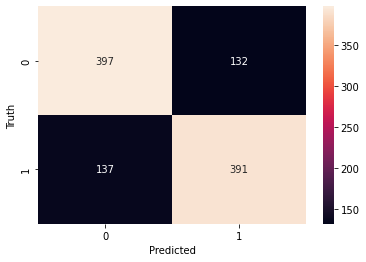

In [18]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')